<a href="https://colab.research.google.com/github/sergiogrmds/Vaccine-Probabilities/blob/main/Vacunas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from collections import Counter
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, roc_curve, auc
from mlxtend.plotting import plot_confusion_matrix

In [2]:
train_labels = pd.read_csv("/content/drive/MyDrive/Vacunas/training_set_labels.csv")
train_values = pd.read_csv("/content/drive/MyDrive/Vacunas/training_set_features.csv")
test_values = pd.read_csv("/content/drive/MyDrive/Vacunas/test_set_features.csv")

In [3]:
print("La dimension del train_labels es:", train_labels.shape)
print("La dimension del train_values es:", train_values.shape)
print("La dimension del test_values es:", test_values.shape)

La dimension del train_labels es: (26707, 3)
La dimension del train_values es: (26707, 36)
La dimension del test_values es: (26708, 36)


In [4]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   respondent_id     26707 non-null  int64
 1   h1n1_vaccine      26707 non-null  int64
 2   seasonal_vaccine  26707 non-null  int64
dtypes: int64(3)
memory usage: 626.1 KB


In [5]:
train = pd.merge(train_labels, train_values)
train = train.drop(["respondent_id"], axis=1)
train.head()

,h1n1_vaccine,seasonal_vaccine,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,0,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,0,0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,0,1,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,0,0,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [6]:
train.duplicated().sum()

0

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_vaccine                 26707 non-null  int64  
 1   seasonal_vaccine             26707 non-null  int64  
 2   h1n1_concern                 26615 non-null  float64
 3   h1n1_knowledge               26591 non-null  float64
 4   behavioral_antiviral_meds    26636 non-null  float64
 5   behavioral_avoidance         26499 non-null  float64
 6   behavioral_face_mask         26688 non-null  float64
 7   behavioral_wash_hands        26665 non-null  float64
 8   behavioral_large_gatherings  26620 non-null  float64
 9   behavioral_outside_home      26625 non-null  float64
 10  behavioral_touch_face        26579 non-null  float64
 11  doctor_recc_h1n1             24547 non-null  float64
 12  doctor_recc_seasonal         24547 non-null  float64
 13  chronic_med_cond

In [8]:
train.isnull().sum()

,0
h1n1_vaccine,0
seasonal_vaccine,0
h1n1_concern,92
h1n1_knowledge,116
behavioral_antiviral_meds,71
behavioral_avoidance,208
behavioral_face_mask,19
behavioral_wash_hands,42
behavioral_large_gatherings,87
behavioral_outside_home,82


In [9]:
train[train.select_dtypes(include="object").columns] = train.select_dtypes(include="object").fillna("Desconocido")
moda_float = train.select_dtypes(include=["float64"]).mode()
moda_int = train.select_dtypes(include=["int64"]).mode()
train.fillna(moda_float, inplace=True)
train.fillna(moda_int, inplace=True)

train.isnull().sum()

,0
h1n1_vaccine,0
seasonal_vaccine,0
h1n1_concern,92
h1n1_knowledge,116
behavioral_antiviral_meds,71
behavioral_avoidance,208
behavioral_face_mask,19
behavioral_wash_hands,42
behavioral_large_gatherings,87
behavioral_outside_home,82


In [10]:
columns_dummies = ["sex", "age_group", "education", "race", "income_poverty", "marital_status", "rent_or_own"]
train = pd.get_dummies(train, columns = ["sex", "age_group", "education", "race", "income_poverty", "marital_status", "rent_or_own"], drop_first=False)

label_encoder = LabelEncoder()

columnas_le = ["employment_status", "hhs_geo_region", "census_msa", "employment_industry", "employment_occupation"]
for col in columnas_le:
  train[col] = label_encoder.fit_transform(train[col])

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 56 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   h1n1_vaccine                              26707 non-null  int64  
 1   seasonal_vaccine                          26707 non-null  int64  
 2   h1n1_concern                              26615 non-null  float64
 3   h1n1_knowledge                            26591 non-null  float64
 4   behavioral_antiviral_meds                 26636 non-null  float64
 5   behavioral_avoidance                      26499 non-null  float64
 6   behavioral_face_mask                      26688 non-null  float64
 7   behavioral_wash_hands                     26665 non-null  float64
 8   behavioral_large_gatherings               26620 non-null  float64
 9   behavioral_outside_home                   26625 non-null  float64
 10  behavioral_touch_face             

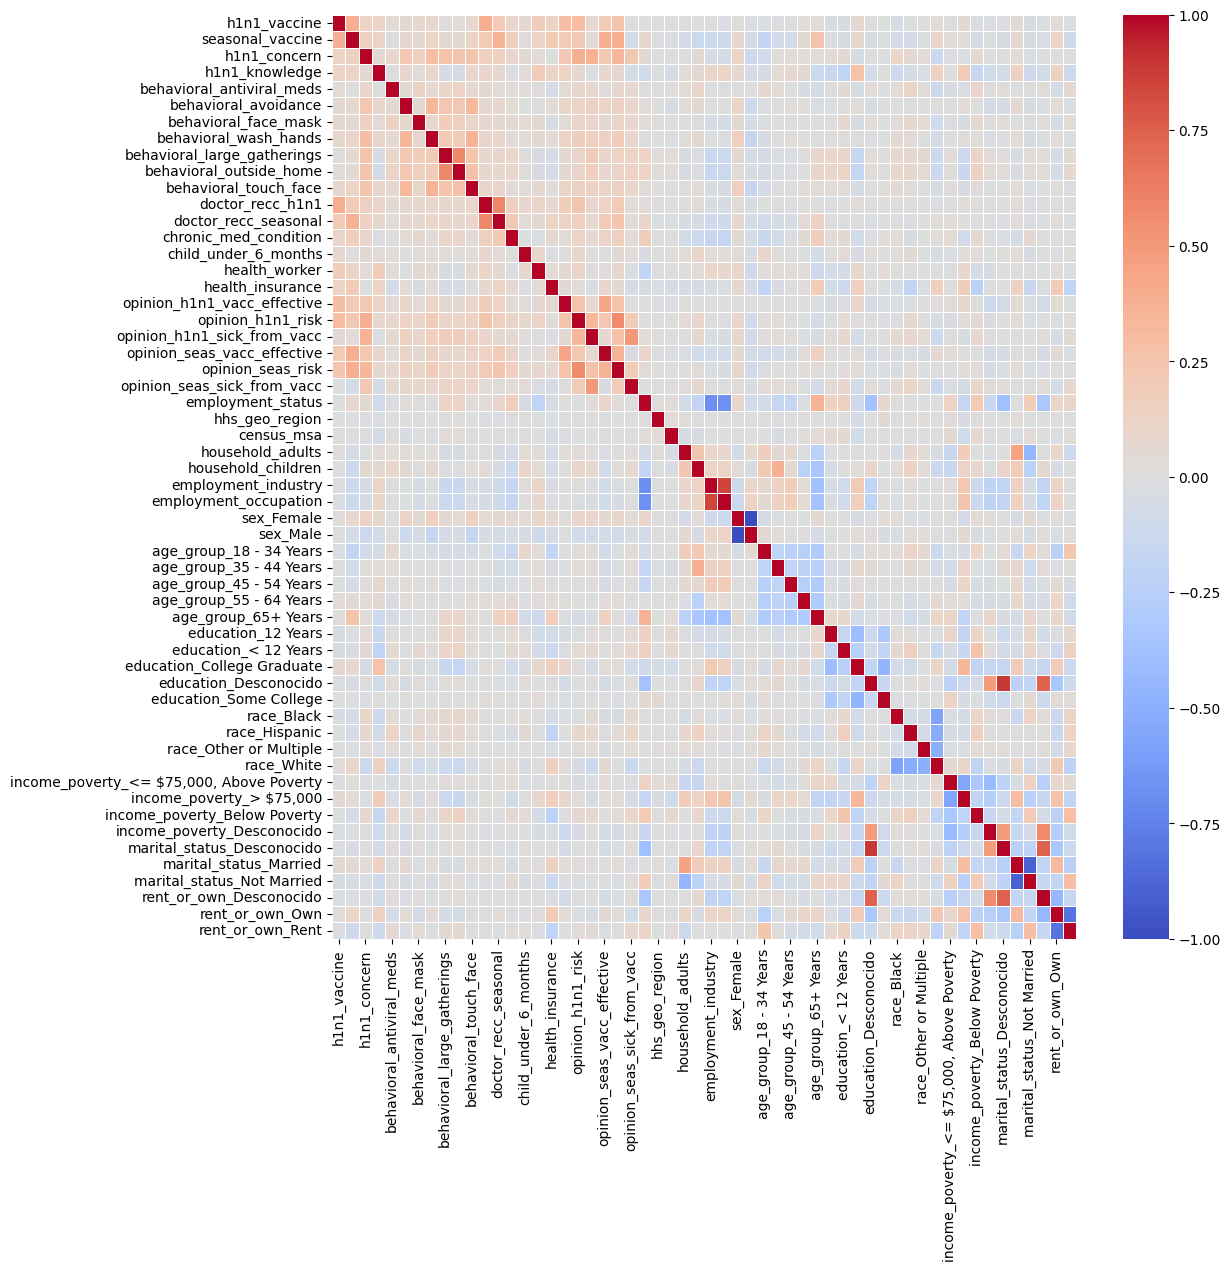

In [11]:
mc = train.corr(method="spearman")

plt.figure(figsize=(12,12))
sns.heatmap(mc, cmap="coolwarm", linewidths=0.5, cbar=True)
plt.show()

In [12]:
corr = abs(train.corr())
corr[["h1n1_vaccine"]].sort_values(by="h1n1_vaccine", ascending=False)

,h1n1_vaccine
h1n1_vaccine,1.000000
doctor_recc_h1n1,0.393890
seasonal_vaccine,0.377143
opinion_h1n1_risk,0.323265
opinion_h1n1_vacc_effective,0.269347
opinion_seas_risk,0.258571
doctor_recc_seasonal,0.209864
opinion_seas_vacc_effective,0.179272
health_worker,0.169768
h1n1_concern,0.121929


In [13]:
corr[["seasonal_vaccine"]].sort_values(by="seasonal_vaccine", ascending=False)

,seasonal_vaccine
seasonal_vaccine,1.000000
opinion_seas_risk,0.390106
h1n1_vaccine,0.377143
doctor_recc_seasonal,0.369190
opinion_seas_vacc_effective,0.361875
age_group_65+ Years,0.244830
opinion_h1n1_risk,0.216625
opinion_h1n1_vacc_effective,0.205072
health_insurance,0.200858
doctor_recc_h1n1,0.198607


In [14]:
y = train[["h1n1_vaccine", "seasonal_vaccine"]]
X = train.drop(["h1n1_vaccine", "seasonal_vaccine"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train = X_train.rename(columns=lambda x: str(x).replace('[', '_').replace(']', '_').replace('<', '_').replace('>', '_'))
X_test = X_test.rename(columns=lambda x: str(x).replace('[', '_').replace(']', '_').replace('<', '_').replace('>', '_'))
y_train = y_train.rename(columns=lambda x: str(x).replace('[', '_').replace(']', '_').replace('<', '_').replace('>', '_'))
y_test = y_test.rename(columns=lambda x: str(x).replace('[', '_').replace(']', '_').replace('<', '_').replace('>', '_'))

In [15]:
RF = RandomForestClassifier(random_state=42)
XGB = XGBClassifier(random_state=42)

In [16]:
multi_RF = MultiOutputClassifier(RF, n_jobs=-1).fit(X_train, y_train)
multi_XGB = MultiOutputClassifier(XGB, n_jobs=-1).fit(X_train, y_train)

In [17]:
pred_RF = [probs[:, 1] for probs in multi_RF.predict_proba(X_test)]

roc_auc_h1n1 = roc_auc_score(y_test['h1n1_vaccine'], pred_RF[0])
print("ROC AUC for h1n1_vaccine:", roc_auc_h1n1)
roc_auc_seasonal = roc_auc_score(y_test['seasonal_vaccine'], pred_RF[1])
print("ROC AUC for seasonal_vaccine:", roc_auc_seasonal)

ROC AUC for h1n1_vaccine: 0.8601375513225807
ROC AUC for seasonal_vaccine: 0.8509683903902009


In [18]:
pred_XGB = [probs[:, 1] for probs in multi_XGB.predict_proba(X_test)]

roc_auc_h1n1 = roc_auc_score(y_test['h1n1_vaccine'], pred_XGB[0])
print("ROC AUC for h1n1_vaccine:", roc_auc_h1n1)
roc_auc_seasonal = roc_auc_score(y_test['seasonal_vaccine'], pred_XGB[1])
print("ROC AUC for seasonal_vaccine:", roc_auc_seasonal)

ROC AUC for h1n1_vaccine: 0.8591384822233555
ROC AUC for seasonal_vaccine: 0.852237199665613


# Predicción

In [19]:
test_values[test_values.select_dtypes(include="object").columns] = test_values.select_dtypes(include="object").fillna("Desconocido")
moda_float = test_values.select_dtypes(include=["float64"]).mode().iloc[0]
moda_int = test_values.select_dtypes(include=["int64"]).mode().iloc[0]
test_values.fillna(moda_float, inplace=True)
test_values.fillna(moda_int, inplace=True)

In [20]:
columns_dummies = ["sex", "age_group", "education", "race", "income_poverty", "marital_status", "rent_or_own"]
test_values = pd.get_dummies(test_values, columns = ["sex", "age_group", "education", "race", "income_poverty", "marital_status", "rent_or_own"], drop_first=False)

label_encoder = LabelEncoder()

columnas_le = ["employment_status", "hhs_geo_region", "census_msa", "employment_industry", "employment_occupation"]
for col in columnas_le:
  test_values[col] = label_encoder.fit_transform(test_values[col])

In [21]:
test_values = test_values.rename(columns=lambda x: str(x).replace('[', '_').replace(']', '_').replace('<', '_').replace('>', '_'))

In [22]:
test_values_proba = test_values.drop(columns="respondent_id")
test_proba = [probs[:,1] for probs in multi_RF.predict_proba(test_values_proba)]
submission_pred_proba = pd.Series(test_proba)

In [23]:
submission_df = pd.DataFrame({
    "respondent_id": test_values["respondent_id"],
    "h1n1_vaccine": test_proba[0],
    "seasonal_vaccine": test_proba[1]
})

print(submission_df.head())

   respondent_id  h1n1_vaccine  seasonal_vaccine
0          26707          0.17              0.43
1          26708          0.07              0.08
2          26709          0.64              0.88
3          26710          0.66              0.89
4          26711          0.31              0.47


In [24]:
submission_df.to_csv("submission.csv", index=False)